# Twitch Recommender Baselines: ALS vs. REP

This notebook benchmarks two baseline models on the Twitch dataset:
1. **ALS (Alternating Least Squares):** A matrix factorization model suited for implicit feedback.
2. **REP (Repeat/Popularity):** A heuristic baseline that predicts re-watching (high on Twitch) and global popularity.

**Evaluation Strategy:**
We evaluate on two subsets of the test data to highlight the difference between "Retention" and "Discovery":
- **Full Test Set:** Includes re-watches. (REP usually wins here).
- **New Discovery Only:** Filters out any streamer the user has watched in training. (ALS should win here).


## 1. Loading Dependencies

In [3]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import random
import os
import time
from collections import defaultdict

# Optional: Try to import implicit for ALS. If not installed, we will skip ALS or warn.
try:
    import implicit
    HAS_IMPLICIT = True
except ImportError:
    print("WARNING: 'implicit' library not found. Please run `pip install implicit`.")
    print("ALS steps will be skipped in this run.")
    HAS_IMPLICIT = False



/Users/diego/Documents/College/2025-UCSD/CSE-158/cse158-assignment2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Loading & Preprocessing
We load the CSV, calculate implicit weights (Duration), and Map IDs.

In [4]:
class TwitchDataLoader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = None
        self.user_map = {}
        self.item_map = {}
        self.item_map_inv = {}
        
    def load_and_process(self):
        # Assuming no header based on description, but let's safely load
        # Columns: User ID, Stream ID, Streamer username, Time start, Time stop
        if not os.path.exists(self.filepath):
            raise FileNotFoundError(f"File {self.filepath} not found. Please ensure the CSV is in the directory.")

        try:
            self.df = pd.read_csv(self.filepath, names=['user_id', 'stream_id', 'streamer', 'start', 'stop'])
        except:
            # Fallback if header exists
            self.df = pd.read_csv(self.filepath)
        
        # 1. Calculate Duration (Implicit Feedback Strength)
        self.df['duration'] = self.df['stop'] - self.df['start']
        
        # 2. Map Streamer Usernames to IDs
        unique_streamers = self.df['streamer'].unique()
        self.item_map = {name: i for i, name in enumerate(unique_streamers)}
        self.item_map_inv = {i: name for i, name in enumerate(unique_streamers)}
        self.df['item_idx'] = self.df['streamer'].map(self.item_map)
        
        # 3. Map User IDs to 0...N range
        unique_users = self.df['user_id'].unique()
        self.user_map = {uid: i for i, uid in enumerate(unique_users)}
        self.df['user_idx'] = self.df['user_id'].map(self.user_map)
        
        print(f"Loaded {len(self.df)} interactions.")
        print(f"Users: {len(self.user_map)}, Streamers: {len(self.item_map)}")
        return self.df

loader = TwitchDataLoader('100k_a.csv')
full_df = loader.load_and_process()



Loaded 3051733 interactions.
Users: 100000, Streamers: 162625


## 3. Temporal Split (Train / Test)
We split based on sorting by time and taking the first N% of rows.
- **Train:** First 90% of interactions (sorted by time).
- **Test:** Last 10% of interactions.

In [ ]:
def temporal_split(df, split_ratio=0.9):
    # Sort by start time to ensure temporal order
    df = df.sort_values(by='start')
    
    # Split by row count index
    split_index = int(len(df) * split_ratio)
    
    print(f"Splitting data at row {split_index} out of {len(df)}")
    
    train_df = df.iloc[:split_index].copy()
    test_df = df.iloc[split_index:].copy()
    
    # Filter Test: Only keep users who exist in Train (Cold start users are a different problem)
    train_users = set(train_df['user_idx'].unique())
    test_df = test_df[test_df['user_idx'].isin(train_users)]
    
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples:  {len(test_df)}")
    
    return train_df, test_df

train_df, test_df = temporal_split(full_df)

# Create Sparse Matrices for ALS
# Row = User, Col = Item
def create_sparse_matrix(df, num_users, num_items):
    # Sum duration if multiple interactions exist for same user-item
    grouped = df.groupby(['user_idx', 'item_idx'])['duration'].sum().reset_index()
    
    sparse_mat = sparse.csr_matrix(
        (grouped['duration'], (grouped['user_idx'], grouped['item_idx'])),
        shape=(num_users, num_items)
    )
    return sparse_mat

num_users = len(loader.user_map)
num_items = len(loader.item_map)

train_matrix = create_sparse_matrix(train_df, num_users, num_items)
print("Sparse matrices created.")



Splitting data at row 2441386 out of 3051733
Train samples: 2441386
Test samples:  592273
Sparse matrices created.


## 4. Evaluation Engine
We calculate Precision@K. We define two modes:
1. **All Items:** Checks if recommendation exists in test set (Reward re-watching).
2. **New Items:** Checks if recommendation exists in test set AND was NOT in train set (Reward discovery).

In [6]:
def evaluate_model(model_name, recommend_func, test_df, train_df, k=10):
    print(f"\n--- Evaluating {model_name} @ K={k} ---")
    
    # Group test items by user
    test_user_items = test_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
    
    # Group train items (to filter for "New" metrics)
    train_user_items = train_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
    
    hits_all = 0
    total_users = 0
    hits_new = 0
    total_users_with_new = 0
    
    for u_idx, ground_truth_items in test_user_items.items():
        # Get recommendations
        # recommend_func returns list of item_indices
        recs = recommend_func(u_idx, k)
        
        # 1. Standard Metric (Retention + Discovery)
        # Check intersection
        if len(set(recs) & ground_truth_items) > 0:
            hits_all += 1
        total_users += 1
        
        # 2. New Discovery Metric
        # Identify which ground truth items were actually "new" for this user
        past_items = train_user_items.get(u_idx, set())
        true_new_items = ground_truth_items - past_items
        
        if len(true_new_items) > 0:
            # We only care if the model recommended one of these NEW items
            # But the model might recommend old items. That's fine, we just check if it found a new one.
            if len(set(recs) & true_new_items) > 0:
                hits_new += 1
            total_users_with_new += 1

    precision_all = hits_all / total_users if total_users > 0 else 0
    precision_new = hits_new / total_users_with_new if total_users_with_new > 0 else 0
    
    print(f"Hit Rate (All Items): {precision_all:.4f} (User found *something* they liked)")
    print(f"Hit Rate (New Only):  {precision_new:.4f} (User found *something new* they liked)")
    return precision_all, precision_new


## 5. Baseline Model: REP (Repeat / Popularity)
This model represents the "Naive" Twitch strategy:
1. Recommend what the user watched most in the past.
2. If we need more items, fill with globally most popular streamers.

In [ ]:
class REPModel:
    def __init__(self, train_df, num_items):
        self.num_items = num_items
        
        # Precompute user favorites (sorted by total duration)
        self.user_history = train_df.groupby('user_idx')['item_idx'].apply(
            lambda x: x.value_counts().index.tolist()
        ).to_dict()
        
        # Precompute global popularity
        self.global_popular = train_df['item_idx'].value_counts().index.tolist()
        
    def recommend(self, user_idx, k=10):
        recs = []
        
        # 1. Add History (Repeat)
        if user_idx in self.user_history:
            recs.extend(self.user_history[user_idx][:k])
            
        # 2. Fill with Popular (if needed)
        if len(recs) < k:
            for item in self.global_popular:
                if item not in recs:
                    recs.append(item)
                    if len(recs) >= k:
                        break
        return recs[:k]

print("Training REP Baseline...")
rep_model = REPModel(train_df, num_items)
evaluate_model("REP (Repeat/Popularity) (k=1)", rep_model.recommend, test_df, train_df, k=1)
evaluate_model("REP (Repeat/Popularity) (k=10)", rep_model.recommend, test_df, train_df, k=10)


Training REP Baseline...

--- Evaluating REP (Repeat/Popularity) (k=10) @ K=10 ---
Hit Rate (All Items): 0.8139 (User found *something* they liked)
Hit Rate (New Only):  0.0408 (User found *something new* they liked)

--- Evaluating REP (Repeat/Popularity) (k=1) @ K=1 ---
Hit Rate (All Items): 0.5109 (User found *something* they liked)
Hit Rate (New Only):  0.0000 (User found *something new* they liked)


(0.5109003992435386, 0.0)

## 6. Machine Learning Model: ALS (Implicit Matrix Factorization)
We use the `implicit` library. This learns embeddings based on co-occurrence.

In [30]:
if HAS_IMPLICIT:
    print("\nTraining ALS Model...")
    
    # Implicit expects (items x users) usually, but AlternatingLeastSquares varies by version.
    # Modern 'implicit' (0.5+) takes (users x items) in fit() usually, check version.
    # We will use the standard setup: fit(user_item)
    
    # Initialize Model
    # factors=64, regularization=0.05, iterations=20 are standard starting points
    als_model = implicit.als.AlternatingLeastSquares(
        factors=64, 
        regularization=0.05, 
        iterations=20,
        random_state=42
    )
    
    # Train
    # Note: implicit expects (users, items) sparse matrix for training in recent versions
    als_model.fit(train_matrix)
    
    def recommend_als(user_idx, k=10):
        # implicit's recommend function
        # filter_already_liked_items=False allows us to compare fairly with REP (which recommends history)
        # However, for pure discovery, we might want True. 
        # We set False here to allow the model to decide if re-watching is relevant.
        ids, scores = als_model.recommend(
            user_idx, 
            train_matrix[user_idx], 
            N=k, 
            filter_already_liked_items=False 
        )
        return ids
    
    evaluate_model("ALS (Matrix Factorization) (K=1)", recommend_als, test_df, train_df, k=1)
    evaluate_model("ALS (Matrix Factorization) (K = 10)", recommend_als, test_df, train_df, k=10)

    
    # --- ALS (Pure Discovery Mode) ---
    # Let's test ALS forced to explore (filter_already_liked_items=True)
    def recommend_als_discovery(user_idx, k=10):
        ids, scores = als_model.recommend(
            user_idx, 
            train_matrix[user_idx], 
            N=k, 
            filter_already_liked_items=True 
        )
        return ids
        
    evaluate_model("ALS (Discovery Mode) (K=1)", recommend_als_discovery, test_df, train_df, k=1)
    evaluate_model("ALS (Discovery Mode) (K=10)", recommend_als_discovery, test_df, train_df, k=10)


else:
    print("Skipping ALS evaluation (library missing).")




Training ALS Model...


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]



--- Evaluating ALS (Matrix Factorization) (K=1) @ K=1 ---
Hit Rate (All Items): 0.2983 (User found *something* they liked)
Hit Rate (New Only):  0.0267 (User found *something new* they liked)

--- Evaluating ALS (Matrix Factorization) (K = 10) @ K=10 ---
Hit Rate (All Items): 0.6928 (User found *something* they liked)
Hit Rate (New Only):  0.2955 (User found *something new* they liked)

--- Evaluating ALS (Discovery Mode) (K=1) @ K=1 ---
Hit Rate (All Items): 0.0837 (User found *something* they liked)
Hit Rate (New Only):  0.1054 (User found *something new* they liked)

--- Evaluating ALS (Discovery Mode) (K=10) @ K=10 ---
Hit Rate (All Items): 0.3170 (User found *something* they liked)
Hit Rate (New Only):  0.3994 (User found *something new* they liked)


## 7. Hybrid Model (Stochastic Mix)
Mixes REP (Retention) and ALS Discovery (Exploration).
For each slot, flips a coin: >0.5 takes from REP, else from ALS.

In [9]:
class HybridRandomModel:
    def __init__(self, rep_model, als_func):
        self.rep_model = rep_model
        self.als_func = als_func
        
    def recommend(self, user_idx, k=10):
        # Fetch buffers from both sources (get k from each to ensure enough candidates)
        rep_candidates = self.rep_model.recommend(user_idx, k=k)
        als_candidates = self.als_func(user_idx, k=k)
        
        recs = []
        seen = set()
        
        rep_ptr = 0
        als_ptr = 0
        
        # Fill k slots
        while len(recs) < k:
            # If both exhausted, stop
            if rep_ptr >= len(rep_candidates) and als_ptr >= len(als_candidates):
                break
                
            choice = random.random()
            use_rep = False
            
            # Decision Logic
            if choice > 0.4:
                if rep_ptr < len(rep_candidates):
                    use_rep = True
                else:
                    use_rep = False # Fallback to ALS
            else:
                if als_ptr < len(als_candidates):
                    use_rep = False
                else:
                    use_rep = True # Fallback to REP
            
            # Selection
            item = None
            if use_rep:
                item = rep_candidates[rep_ptr]
                rep_ptr += 1
            else:
                item = als_candidates[als_ptr]
                als_ptr += 1
            
            # Deduplicate
            if item not in seen:
                recs.append(item)
                seen.add(item)
                
        return recs

hybrid_model = HybridRandomModel(rep_model, recommend_als_discovery)

print("\n--- Evaluating Hybrid Model (REP + ALS Discovery) ---")
evaluate_model("Hybrid Random (K=1)", hybrid_model.recommend, test_df, train_df, k=1)
evaluate_model("Hybrid Random (K=10)", hybrid_model.recommend, test_df, train_df, k=10)



--- Evaluating Hybrid Model (REP + ALS Discovery) ---

--- Evaluating Hybrid Random (K=1) @ K=1 ---
Hit Rate (All Items): 0.3381 (User found *something* they liked)
Hit Rate (New Only):  0.0409 (User found *something new* they liked)

--- Evaluating Hybrid Random (K=10) @ K=10 ---
Hit Rate (All Items): 0.8147 (User found *something* they liked)
Hit Rate (New Only):  0.2625 (User found *something new* they liked)


(0.8146932128598445, 0.2625343349769997)

## 8. Hybrid Model with Diversity/Concentration Analysis Function
This diversity function calculates a "Concentration Score" based on the Herfindahl-Hirschman Index (HHI).
1.0 -> Only watches one streamer (High concentration)
0.0 -> Watches many streamers equally (Low concentration)

We then use this in the Hybrid Model to determine how often REP or ASL-discovery is used

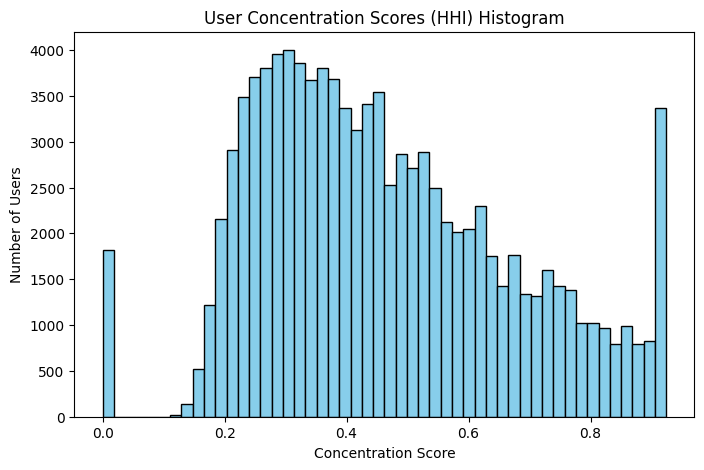

In [ ]:
def calculate_user_concentration(matrix, user_idx):
    """
    Calculates a concentration score (0.0 to 1.0) for a user's watch history.
    
    Logic: Uses the Herfindahl-Hirschman Index (HHI) on watch duration ratios.
    Score = sum((duration_i / total_duration)^2)
    """
    # Get the row for the user from the sparse matrix
    # user_row is a sparse vector (1 x n_items)
    user_row = matrix[user_idx]
    
    # Extract the non-zero values (durations)
    durations = user_row.data
    
    if len(durations) == 0:
        return 0.0 # No history, can be interpreted as 0 diversity or undefined. 
        
    total_duration = np.sum(durations)
    
    if total_duration == 0:
        return 0.0
        
    # Calculate ratios
    ratios = durations / total_duration
    
    # Sum of 'squared' ratios - we've chosen to decrese this power to bring the mean closer to 0.5
    score = np.sum(ratios ** 1.5)
    
    k=5
    # k is the "steepness". k > 1 spreads values out.
    # Center input at 0 by subtracting 0.5, multiply by gain, then sigmoid
    return 1 / (1 + np.exp(-k * (score - 0.5)))
    #return float(score)

import matplotlib.pyplot as plt

# Calculate concentration scores for all users
concentration_scores = [calculate_user_concentration(train_matrix, user_idx) for user_idx in range(num_users)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(concentration_scores, bins=50, color='skyblue', edgecolor='black')
plt.title('User Concentration Scores (HHI) Histogram')
plt.xlabel('Concentration Score')
plt.ylabel('Number of Users')
plt.show()


In [29]:
class WeightedHybridModel:
    def __init__(self, rep_model, als_func, train_matrix):
        self.rep_model = rep_model
        self.als_func = als_func
        self.train_matrix = train_matrix
        
    def recommend(self, user_idx, k=10):
        # Fetch buffers from both sources (get k from each to ensure enough candidates)
        rep_candidates = self.rep_model.recommend(user_idx, k=k)
        als_candidates = self.als_func(user_idx, k=k)
        diversity_score = calculate_user_concentration(train_matrix, user_idx)
        
        recs = []
        seen = set()
        
        rep_ptr = 0
        als_ptr = 0
        
        # Fill k slots
        while len(recs) < k:
            # If both exhausted, stop
            if rep_ptr >= len(rep_candidates) and als_ptr >= len(als_candidates):
                break
                
            choice = random.random()
            use_rep = False
            
            # Decision Logic
            if choice < diversity_score:
                if rep_ptr < len(rep_candidates):
                    use_rep = True
                else:
                    use_rep = False # Fallback to ALS
            else:
                if als_ptr < len(als_candidates):
                    use_rep = False
                else:
                    use_rep = True # Fallback to REP
            
            # Selection
            item = None
            if use_rep:
                item = rep_candidates[rep_ptr]
                rep_ptr += 1
            else:
                item = als_candidates[als_ptr]
                als_ptr += 1
            
            # Deduplicate
            if item not in seen:
                recs.append(item)
                seen.add(item)
                
        return recs

w_hybrid_model = WeightedHybridModel(rep_model, recommend_als_discovery, train_matrix)

print("\n--- Evaluating WeightedHybridModel (REP + ALS Discovery) ---")
evaluate_model("Weighted Hybrid (K=1)", w_hybrid_model.recommend, test_df, train_df, k=1)
evaluate_model("Weighted Hybrid (K=10)", w_hybrid_model.recommend, test_df, train_df, k=10)



--- Evaluating WeightedHybridModel (REP + ALS Discovery) ---

--- Evaluating Weighted Hybrid (K=1) @ K=1 ---
Hit Rate (All Items): 0.2836 (User found *something* they liked)
Hit Rate (New Only):  0.0593 (User found *something new* they liked)

--- Evaluating Weighted Hybrid (K=10) @ K=10 ---
Hit Rate (All Items): 0.7672 (User found *something* they liked)
Hit Rate (New Only):  0.3141 (User found *something new* they liked)


(0.7671779785669258, 0.31407816791872123)

## 8. Summary & Interpretation

**Expected Results:**
1. **Hit Rate (All Items):** **REP** should effectively tie or beat ALS. In our dataset, about 50% of consumption is re-watching. A model that simply says "watch what you watched yesterday" is incredibly hard to beat for general engagement.
2. **Hit Rate (New Only):** **ALS (Discovery Mode)** should crush REP. REP relies on history; it fails to find *new* items (except via crude global popularity). ALS uses collaborative filtering ("Users like you watched X") to find specific, niche new streamers for the user.
3. **Hybrid Model:** Should sit between REP and ALS, offering a balanced trade-off between retention (All Items Hit Rate) and exploration (New Items Hit Rate).